## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import urllib
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from google.colab import drive

**QUESTION:** Load dataset and display some lines of the csv file.

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IA embarquee/data/ai4i2020.csv")
print(df)

MessageError: Error: credential propagation was unsuccessful

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

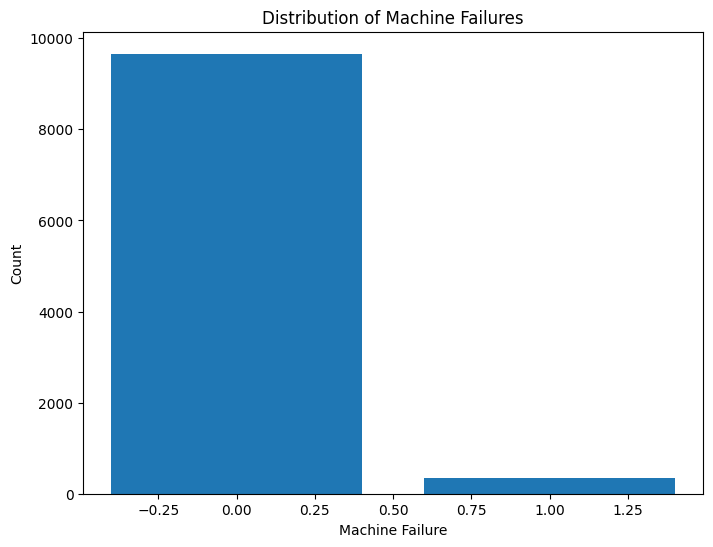

In [ ]:
failure_counts = df['Machine failure'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(failure_counts.index, failure_counts.values)
plt.xlabel('Machine Failure')
plt.ylabel('Count')
plt.title('Distribution of Machine Failures')
plt.show()


**ANALYSIS QUESTION:** What do you observe?

La proportion de machines en maintenance est très faible comparée à celle de machines fonctionnelles

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Cela nous fait peu de données pour entrainer le model qui sera donc en underfiting


**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

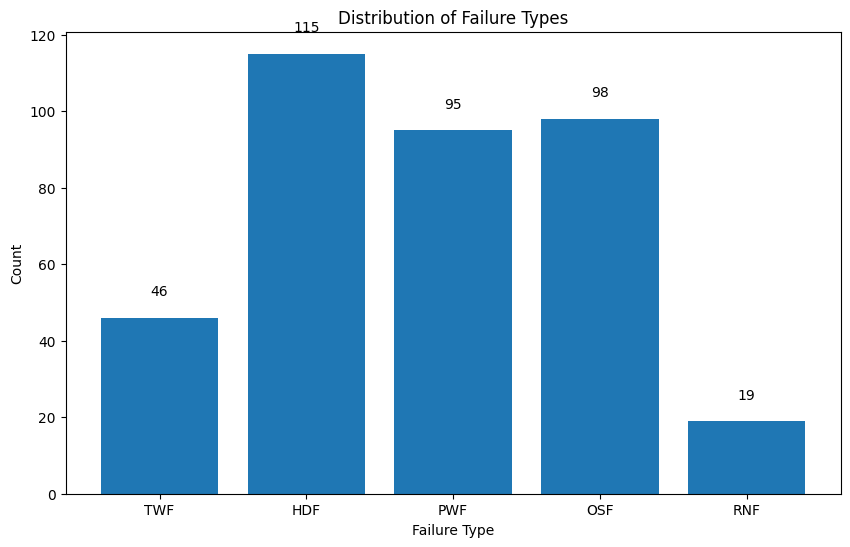

In [ ]:
# prompt: Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart

import matplotlib.pyplot as plt
failure_TWF_counts = df['TWF'].value_counts()
failure_HDF_counts = df['HDF'].value_counts()
failure_PWF_counts = df['PWF'].value_counts()
failure_OSF_counts = df['OSF'].value_counts()
failure_RNF_counts = df['RNF'].value_counts()
fail_tot = [failure_TWF_counts[1], failure_HDF_counts[1], failure_PWF_counts[1], failure_OSF_counts[1], failure_RNF_counts[1]]
labels = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, fail_tot)
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.title('Distribution of Failure Types')

# Add exact values above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, yval, ha='center', va='bottom')

plt.show()


**ANALYSIS QUESTION:** What do you observe?

"Write here your response"

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

Commentaire perso : Revoir les données, il y a moyen que si une machine a 2 types de failure, on n'en compte qu'uen seule ce qui réduit nos chiffres ( verifier avec Pablo qui a des valeurs différentes )

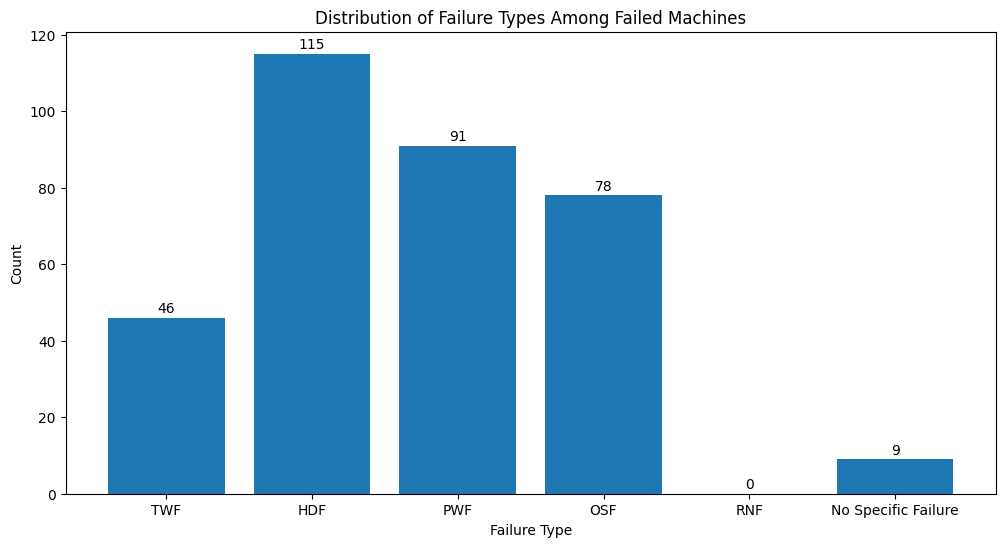

In [ ]:
# prompt: Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

failed_machines = df[df['Machine failure'] == 1]

failure_type_counts = {
    'TWF': 0,
    'HDF': 0,
    'PWF': 0,
    'OSF': 0,
    'RNF': 0,
    'No Specific Failure': 0
}

for index, row in failed_machines.iterrows():
    failure_found = False
    for failure_type in ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']:
        if row[failure_type] == 1:
            failure_type_counts[failure_type] += 1
            failure_found = True
            break

    if not failure_found:
        failure_type_counts['No Specific Failure'] += 1

labels = list(failure_type_counts.keys())
counts = list(failure_type_counts.values())

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts)
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.title('Distribution of Failure Types Among Failed Machines')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')  # Adjust vertical position

plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

On observe une différence dans les données. Cela est dû a la restriction Machine failure == 1. Cela traduit des données qui peuvent incohérente : avoir un type de failure mais pas de machine failure. Cela nous rapproche d'une cas industriel plus réaliste avec un traitement de données nécessaire

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [ ]:
df.dtypes

,0
UDI,int64
Product ID,object
Type,object
Air temperature [K],float64
Process temperature [K],float64
Rotational speed [rpm],int64
Torque [Nm],float64
Tool wear [min],int64
Machine failure,int64
TWF,int64


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

Nous prenons en entrée les différentes données de liées à l'environnement : La température de l'air, le processus de temperature, la vitesse rationnelle, le couple de tension et l'usure des outils. A partir de ces éléments, le modèle prédit le type de failure. Les sorties correspondent donc à la valeur de machine failure ainsi que les 5 types de failures.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

**QUESTION** Code below the model architecture

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

**QUESTION** Code below the algorithms allowing to train model


**QUESTION** Plot the confusion matrix and the classification report

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"